In [1]:
import os
import pandas as pd
import numpy as np
import h2o
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 42
NEW_WORLD_RANDOM_STATE = 88
N_SAMPLES_HOLDOUT = 20000

MODELS_DIR = '../models/'
HOLDOUT_DATA_DIR = '../data/03_holdout/'
HOLDOUT_DATA_PATH = os.path.join(HOLDOUT_DATA_DIR, 'new_world_holdout.csv')

os.makedirs(HOLDOUT_DATA_DIR, exist_ok=True)
h2o.init(nthreads=-1, max_mem_size="10g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-17.0.16+8 (build 17.0.16+8, mixed mode, sharing)
  Starting server from C:\Project\Synthetic Intelligence\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\bharg\AppData\Local\Temp\tmpy02cuwwt
  JVM stdout: C:\Users\bharg\AppData\Local\Temp\tmpy02cuwwt\h2o_bharg_started_from_python.out
  JVM stderr: C:\Users\bharg\AppData\Local\Temp\tmpy02cuwwt\h2o_bharg_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 7 days
H2O_cluster_name:,H2O_from_python_bharg_rdpnmd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


# Generate "New World" Holdout Dataset

In [3]:
def create_new_world_dataset():
    """Generates a completely new, unseen, imbalanced dataset to test generalisation."""
    print(f"Generating 'New World' holdout dataset with {N_SAMPLES_HOLDOUT} samples...")

    X_num, y = make_classification(
        n_samples=N_SAMPLES_HOLDOUT,
        n_features=30,
        n_informative=15,
        n_redundant=5,
        n_classes=2,
        class_sep=0.75,
        flip_y=0.06,
        weights=[0.92, 0.08],
        random_state=NEW_WORLD_RANDOM_STATE
    )
    df_numerical = pd.DataFrame(X_num, columns=[f'num_{i}' for i in range(X_num.shape[1])])

    df_categorical = pd.DataFrame()
    for i in range(10):
        num_categories = np.random.randint(3, 15)
        categories = [f'cat_{i}_val_{j}' for j in range(num_categories)]
        cat_data = np.random.choice(categories, size=N_SAMPLES_HOLDOUT)
        df_categorical[f'cat_{i}'] = pd.Series(cat_data, dtype='category')
    
    df_holdout = pd.concat([df_numerical, df_categorical, pd.Series(y, name='target')], axis=1)

    print("New World dataset class distribution:")
    print(df_holdout['target'].value_counts(normalize=True))

    df_holdout.to_csv(HOLDOUT_DATA_PATH, index=False)
    print(f"Saved new holdout dataset to {HOLDOUT_DATA_PATH}")

    return df_holdout

df_holdout = create_new_world_dataset()
hf_holdout = h2o.H2OFrame(df_holdout)
hf_holdout['target'] = hf_holdout['target'].asfactor()

Generating 'New World' holdout dataset with 20000 samples...
New World dataset class distribution:
target
0    0.8962
1    0.1038
Name: proportion, dtype: float64
Saved new holdout dataset to ../data/03_holdout/new_world_holdout.csv
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Load trained models

def get_trained_model(model_name):
    """Loads a saved H2O model."""
    model_path = os.path.join(MODELS_DIR, f"{model_name}.model")
    if os.path.exists(model_path):
        print(f"Loading saved model: {model_name}...")
        return h2o.load_model(model_path)
    else:
        raise FileNotFoundError(f"Model file not found at {model_path}. Please run previous notebooks to train and save the models.")

model_imbalanced = get_trained_model("imbalanced_leader")
model_smote = get_trained_model("smote_leader")
model_model_driven = get_trained_model("model_driven_leader")

try:
    smote_predictors = model_smote.varimp(use_pandas=True)['variable'].tolist()
except:
    smote_predictors = model_smote._model_json['output']['names'][:-1]

Loading saved model: imbalanced_leader...
Loading saved model: smote_leader...
Loading saved model: model_driven_leader...


# Evaluate Generalisation Performance

In [ ]:
def evaluate_model(model, test_hf, model_name, one_hot_predictors=None, response="target"):
    """Helper function to evaluate a model on the new holdout set."""
    if one_hot_predictors:
        test_df = test_hf.as_data_frame()
        test_df_encoded = pd.get_dummies(test_df)

        test_df_encoded = test_df_encoded.reindex(columns=one_hot_predictors + [response], fill_value=0)

        test_hf_eval = h2o.H2OFrame(test_df_encoded)

        for col in one_hot_predictors:
            if col.startswith('cat_'):
                test_hf_eval[col] = test_hf_eval[col].asfactor()

        test_hf_eval[response] = test_hf_eval[response].asfactor()
    else:
        test_hf_eval = test_hf
        test_hf_eval[response] = test_hf_eval[response].asfactor()
    
    perf = model.model_performance(test_hf_eval)
    return {
        "Model": model_name,
        "AUPRC": perf.aucpr(),
        "F1": perf.F1()[0][1],
        "AUC": perf.auc(),
        "Precision": perf.precision()[0][1],
        "Recall": perf.recall()[0][1]
    }

In [ ]:
# Evaluate all models on the "New World" holdout dataset
results = []

results.append(evaluate_model(model_imbalanced, hf_holdout, "Imbalanced"))

results.append(evaluate_model(model_smote, hf_holdout, "SMOTE", one_hot_predictors=smote_predictors))

# Evaluate the model trained with model-driven sampling
results.append(evaluate_model(model_model_driven, hf_holdout, "Model-Driven"))

df_final = pd.DataFrame(results)
df_final.set_index('Model', inplace=True)

print("--- Generalization Test Results on 'New World' Dataset ---")
print(df_final)

c:\Project\Synthetic Intelligence\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
--- Generalization Test Results on 'New World' Dataset ---
                 AUPRC        F1       AUC  Precision  Recall
Model                                                        
Imbalanced    0.097890  0.188078  0.474080   0.333333     1.0
SMOTE         0.099745  0.188078  0.491889   0.104337     1.0
Model-Driven  0.103295  0.189180  0.513198   0.176471     1.0


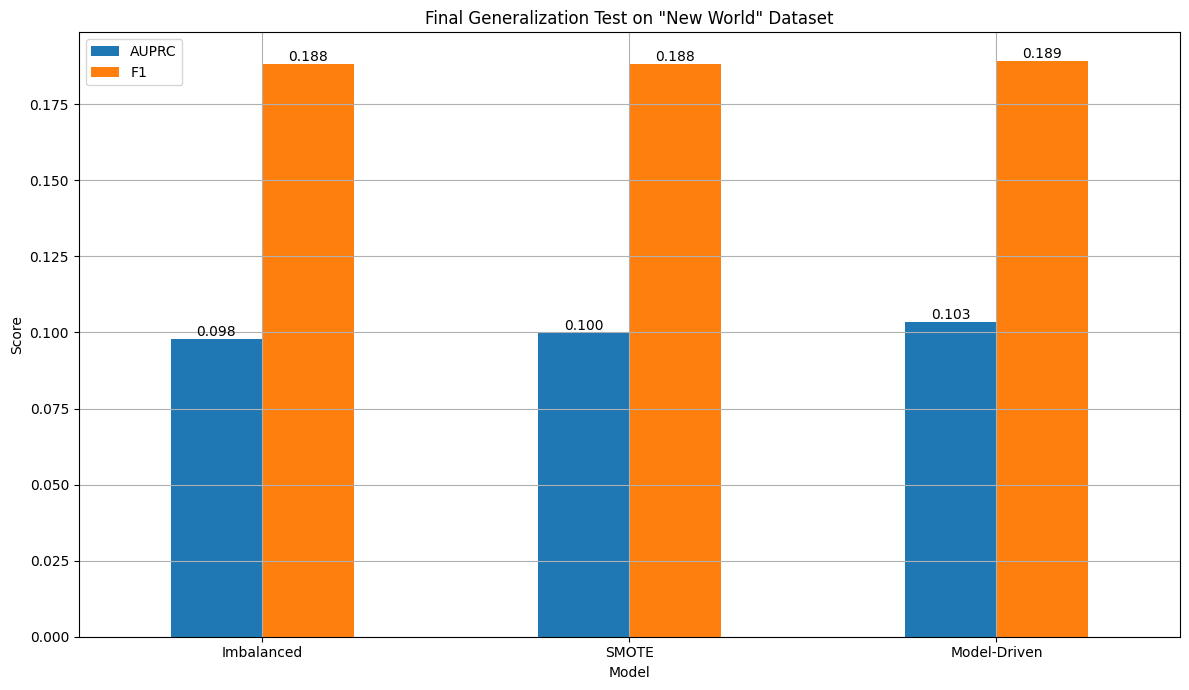

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics_to_plot = ['AUPRC', 'F1']
ax = df_final[metrics_to_plot].plot(
    kind='bar',
    figsize=(12, 7),
    grid=True,
    title='Final Generalization Test on "New World" Dataset',
    ylabel='Score',
    color=['#1f77b4', '#ff7f0e']  
)

plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()